# Multivariate Forecasting: VAR vs. LSTM

## Objective

Factor investing has gained significant traction as a systematic and academically-backed approach to harvesting additional risk premiums in financial markets. However, the performance of these investment strategies is notoriously unstable, making it challenging for investors to maintain confidence in them. In this analysis, we will examine the return time series of various investment strategies to gain insights into their codependent returns over time. These insights will assist investors, asset managers, and other stakeholders in making informed decisions when selecting or advocating for particular investment strategies.

## Data Set Description

The monthly return data used in this analysis are from the paper [**How Do Factor Premia Vary Over Time? A Century of Evidence**](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3400998) by Ilmanen et al. (2019). It explores the following four factor strategies across liquid asset classes:

- **Value**: A strategy that focuses on investing in undervalued assets, which are expected to generate higher returns compared to their overvalued counterparts.
- **Momentum**: A strategy that capitalizes on the continuation of existing price trends, buying assets that have been performing well and selling those that have been underperforming.
- **Carry**: A strategy that seeks to profit from the differences in interest rates, dividend yields, or other sources of income across various assets, investing in higher-yielding assets and shorting lower-yielding ones.
- **Defensive**: A strategy that aims to minimize risks and protect against market downturns, typically by investing in assets with low volatility, high-quality financials, or other defensive characteristics.

In [298]:
import pandas as pd

# Load the dataset
data = pd.read_csv('data_project.csv', sep=';')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Rename the columns
data = data.rename(columns={
    'All asset classes Value': 'Value',
    'All asset classes Momentum': 'Momentum',
    'All asset classes Carry': 'Carry',
    'All asset classes Defensive': 'Defensive'
})

# Display the data
display(data.head())

,Value,Momentum,Carry,Defensive
Date,,,,
1926-07-30,0.016,-0.016,-0.013,-0.016
1926-08-31,-0.001,0.025,0.002,-0.010
1926-09-30,0.011,0.012,-0.019,0.017
1926-10-29,0.013,0.013,-0.011,-0.030
1926-11-30,0.016,0.007,0.014,-0.023


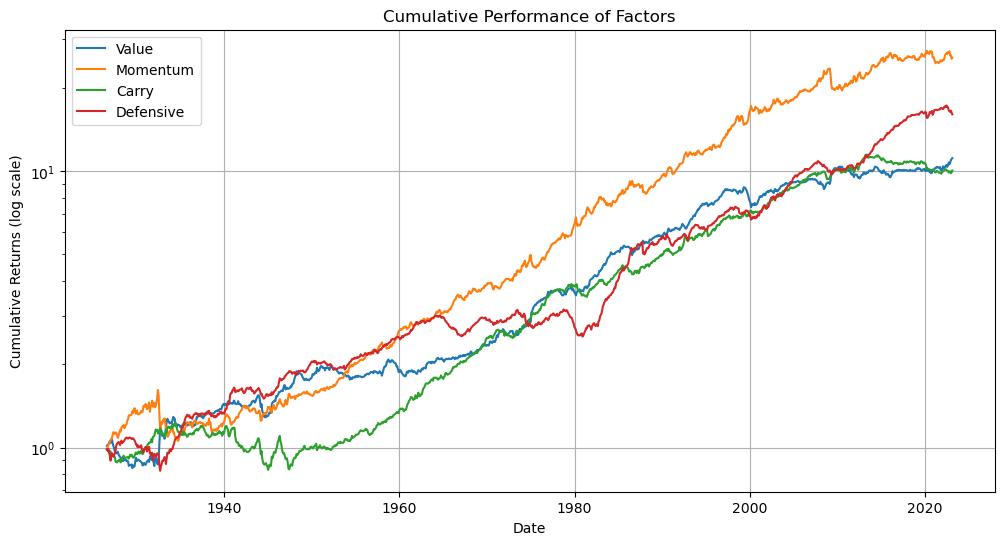

In [299]:
import matplotlib.pyplot as plt

# Calculate the cumulative returns of the factors
cumulative_returns = (1 + data).cumprod()

# Plot the cumulative returns with a log-scaled y-axis
plt.figure(figsize=(12, 6))
plt.yscale('log')
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (log scale)')
plt.title('Cumulative Performance of Factors')
plt.grid()
plt.legend()

# Show the plot
plt.show()

## Data Exploration

First, let's get a visual impression:

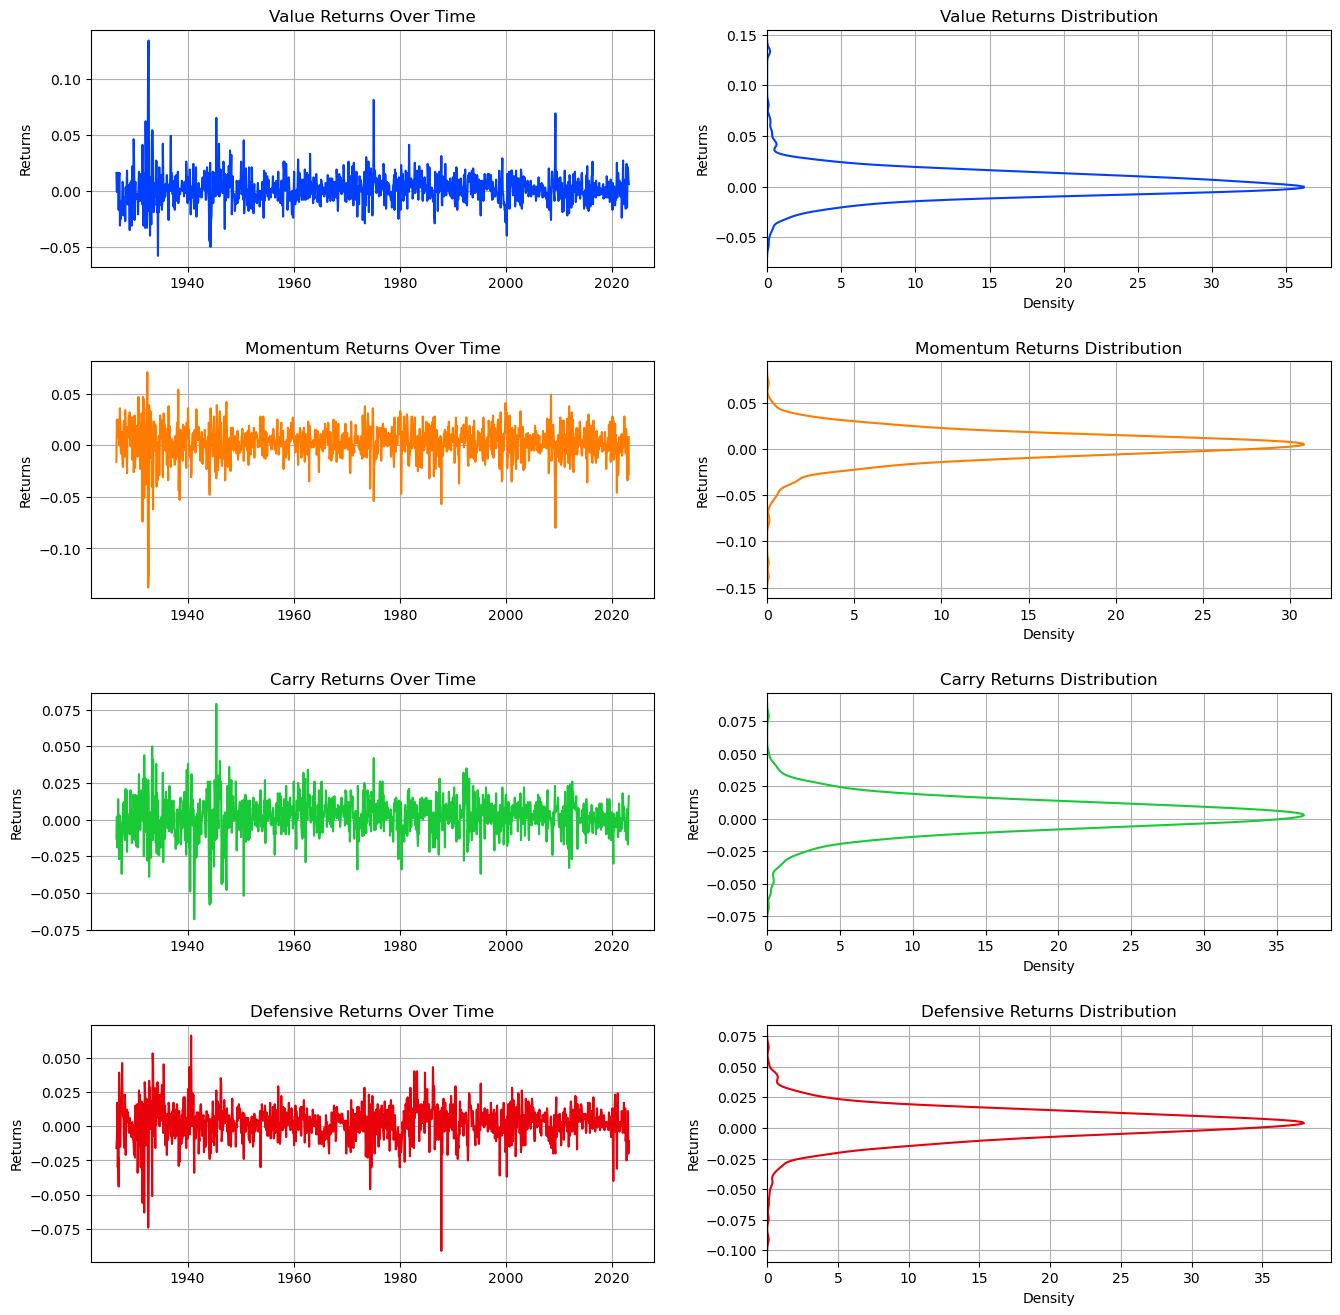

In [300]:
# Define a color palette with four colors
palette = sns.color_palette('bright', n_colors=4)

# Create a 4-row, 2-column grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

# Iterate through the columns and create a line plot and a density plot for each factor
for i, column in enumerate(data.columns):
    # Plot the line plot
    ax = axes[i, 0]
    ax.plot(data.index, data[column], label=column, color=palette[i])
    ax.set_ylabel('Returns')
    ax.set_title(f'{column} Returns Over Time')
    ax.grid()
    
    # Plot the density plot
    ax = axes[i, 1]
    sns.kdeplot(y=data[column], ax=ax, color=palette[i])
    ax.set_xlabel('Density')
    ax.set_ylabel('Returns')
    ax.set_title(f'{column} Returns Distribution')
    ax.grid()

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.4)

# Display the plots
plt.show()

Let's look at some descriptive statistics:

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display descriptive statistics
display(data.describe())

,Value,Momentum,Carry,Defensive
count,1160.000000,1160.000000,1160.000000,1160.000000
mean,0.002178,0.002940,0.002076,0.002480
std,0.014046,0.016448,0.012929,0.012953
min,-0.058000,-0.138000,-0.068000,-0.091000
25%,-0.005000,-0.005000,-0.005000,-0.004000
50%,0.001000,0.004000,0.003000,0.003000
75%,0.009000,0.012000,0.009000,0.010000
max,0.134000,0.071000,0.079000,0.066000


These first descriptive statistics reveal some first insights about their behaviour & risk:

- The **mean** returns are as follows: Value (0.22%), Momentum (0.29%), Carry (0.21%), and Defensive (0.25%). This indicates that, on average, Momentum has the highest return, followed by the Defensive, Value, and Carry.

- The **standard deviation**, a measure of risk, is highest for Momentum (1.64%), followed by Value (1.40%), Defensive (1.30%), and Carry (1.29%). This suggests that Momentum has been the riskiest, while the Carry and Defensive have been relatively less risky.

- The **minimum** and **maximum** returns for each factor show that Momentum has experienced the most extreme gains and losses. It has the lowest minimum return (-13.8%) and the highest maximum return (13.4%). Value has the second-highest maximum return (13.4%) but a less extreme minimum return (-5.8%). Defensive and Carry have relatively smaller ranges for their returns, indicating less extreme gains and losses.

- The **interquartile range** (IQR), which represents the range between the 25th and 75th percentiles, can provide insights into the distribution of the returns. The IQRs for the factors are relatively similar, with Momentum having a slightly wider range (1.7%) compared to the others (Value: 1.4%, Carry: 1.4%, and Defensive: 1.4%). This suggests that the returns for Momentum are more spread out than the other factors.

In summary, Momentum has delivered the highest average returns but has also been the riskiest, with the most extreme gains and losses. Carry and Defensive have been less risky, with smaller standard deviations and less extreme gains and losses. Value has exhibited a performance profile somewhat in between the other factors.

Their co-dependency is best visualialized by a correlation matrix:

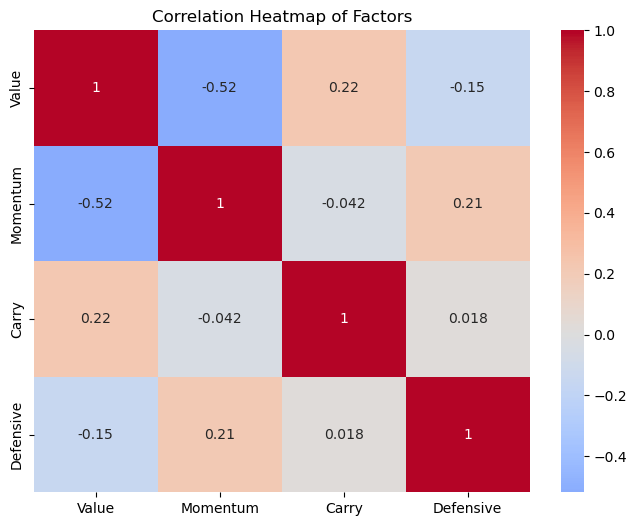

In [302]:
# Create a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap of Factors')
plt.show()

The estimated correlations between the four factors provide insights into their relationships and potential diversification benefits. Here are some key observations:

- The most notable correlation is the strong negative relationship between **Value and Momentum** (-0.52). This suggests that when Value performs well, Momentum tends to perform poorly, and vice versa. This could be expected, as Value focuses on undervalued assets, while Momentum targets assets with strong price trends, which might no longer be undervalued.

- The positive correlation between **Value and Carry** (0.22) indicates a mild positive relationship between their performances. This could also be expected, as cheap equties tend to be high-yielding.

- The negative correlation between **Value and Defensive** (-0.15) suggests a weak negative relationship between their performances. This could also be expected as cheap equities tend to be of low fundamental quality, what defensive ones are by definition not. However, the relatively low correlation value indicates that this relationship is not very strong.

- The positive correlation between **Momentum and Defensive** (0.21) reveals a mild positive relationship between their performances. This could also be expected as both factors tend to do well during market down turns.

- The correlations between the **Carry and the other factors** are relatively low (Momentum: -0.04, Defensive: 0.02). This suggests that Carry's performance is mostly independent of the other factors, which offers diversification benefits to investors.

In summary, the strong negative correlation between the Value and Momentum factors and the low correlations between the Carry factor and other factors offer potential diversification benefits for investors.

Now let's turn to statistics for time series data, such as the autorrelation to visualize patterns in the data:

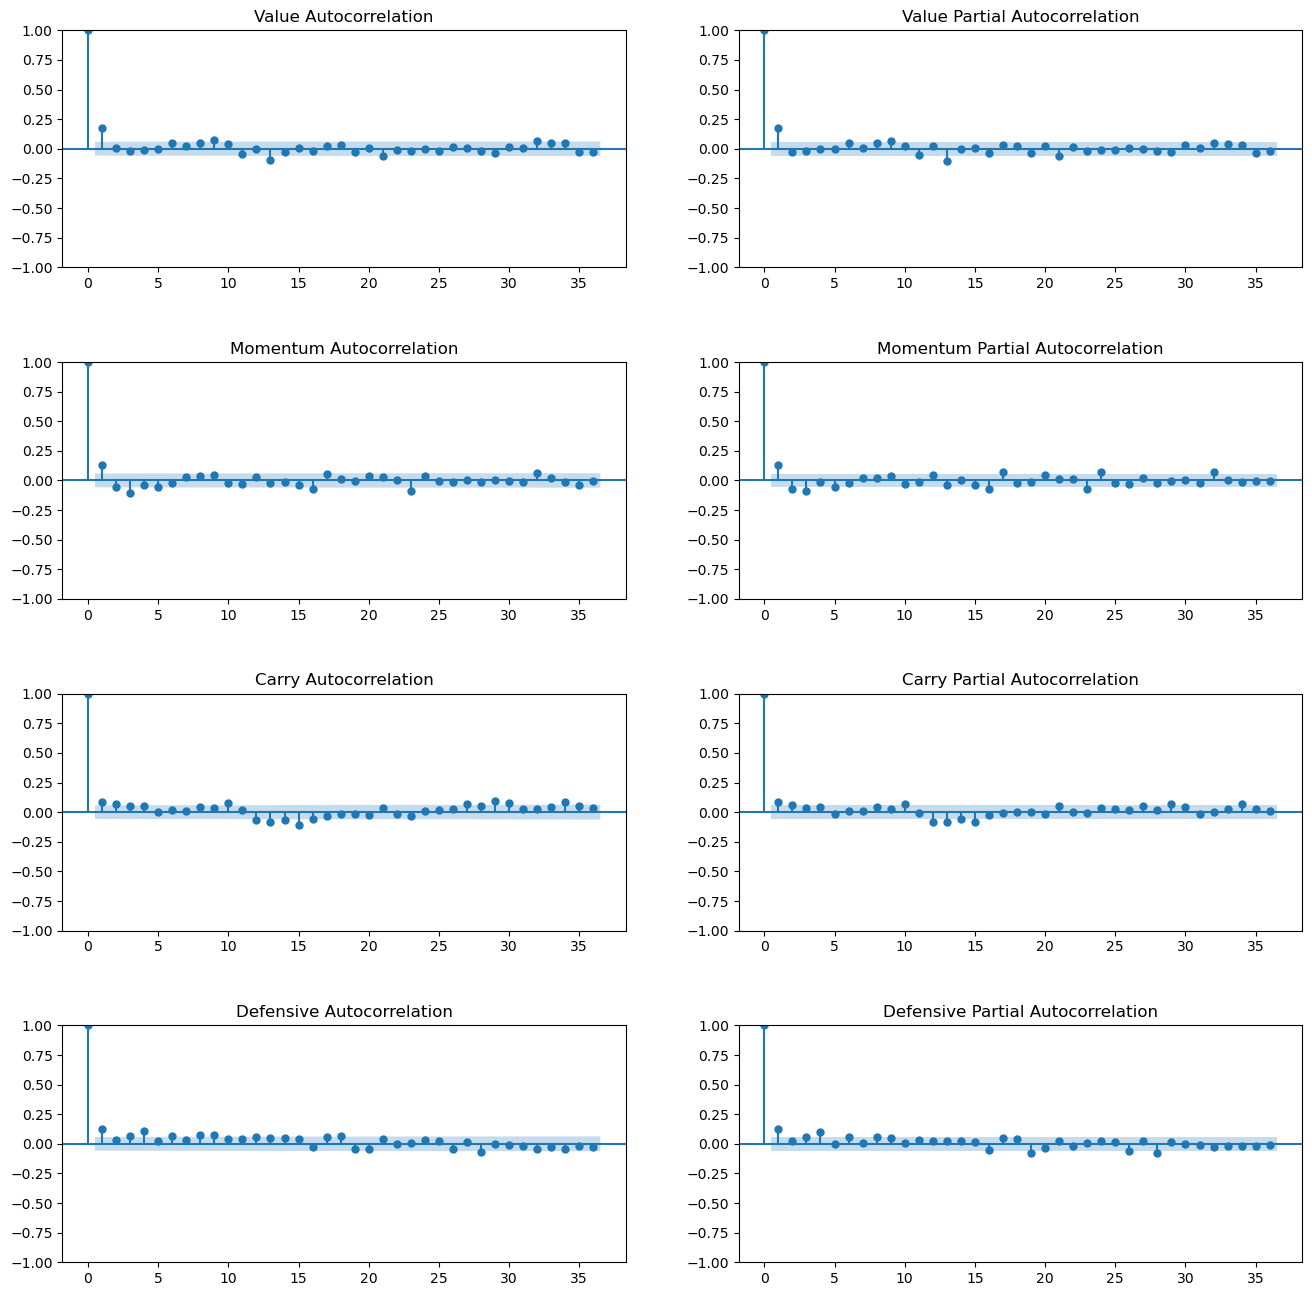

In [303]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a 4-row, 2-column grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

# Iterate through the columns and create ACF and PACF plots for each factor
for i, column in enumerate(data.columns):
    # Plot the ACF
    ax = axes[i, 0]
    plot_acf(data[column], ax=ax, lags=36, title=f'{column} Autocorrelation')
    
    # Plot the PACF
    ax = axes[i, 1]
    plot_pacf(data[column], ax=ax, lags=36, method='ywm', title=f'{column} Partial Autocorrelation')

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.4)

# Display the plots
plt.show()

The plots show the autocorrelations of the four factors (Value, Momentum, Carry, and Defensive) up to 36 lags. 36 to lags, because, it is well known that sometimes there are long term mean reversion effects at this horizon, which we don't want to miss.

Overall, for all four factors, there's a weak positive autocorrelation at lag 1, and the autocorrelations are relatively small for the other lags. This indicates that the linear dependence between the returns at time t and the returns at other lags is quite weak, suggesting a low level of predictability based on past returns.

As a final exploratory step, we want to formally test for stationarity with the augmented Dickey-Fuller test and confirm our visual impression that it is present, despite some volatility clustering, i.e. non-constant volatility, that is typical of financial time series data.

In [304]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Create an empty DataFrame to store the ADF test results
adf_results = pd.DataFrame(columns=['Factor', 'ADF Statistic', 'p-value'])

# Iterate through the columns and perform the ADF test for each factor
for column in data.columns:
    # Perform the ADF test
    adf_result = adfuller(data[column])
    adf_statistic = adf_result[0]
    p_value = adf_result[1]

    # Append the results to the DataFrame
    result_row = pd.DataFrame({
        'Factor': [column],
        'ADF Statistic': [adf_statistic],
        'p-value': [p_value]
    })

    adf_results = pd.concat([adf_results, result_row], ignore_index=True)

# Display the ADF test results in a table
display(adf_results)

,Factor,ADF Statistic,p-value
0,Value,-9.362642,7.748765e-16
1,Momentum,-6.991029,7.744350e-10
2,Carry,-10.339862,2.702888e-18
3,Defensive,-8.765400,2.605895e-14


For all four factors, the ADF statistic is negative and the p-value is very close to zero (0.000). This suggests that we can reject the null hypothesis of the presence of a unit root in the time series for each factor. In other words, the test provides strong evidence that all four factors  returns are stationary time series. This is a desirable property for further time series analysis and modeling, as stationary series are easier to work with and produce more reliable forecasts.

## Model Training

In this step I want to fit the following two multivariate models, as we deal with multiple time series, which share some codependency as we have seen above:

- **VAR (Vector Autoregression)**: This is a linear model that captures the dynamic relationship between multiple time series by regressing each series on its own past values and the past values of the other series.
- **Multivariate LSTM**: This is a deep learning model that uses recurrent neural networks, specifically Long Short-Term Memory (LSTM) units, to capture complex temporal dependencies and interactions among multiple time series.

### VAR (Vector Autoregression)

First of all, we split the data into a training and test data set.

The VAR model will be fitted on ``df_train`` and then used to forecast the next 12 months (1 year), sind this is a common investment horizon, stakeholders consider, when making allocation decisions. These forecasts will be compared against the actuals present in test data.

In [305]:
nobs = 12
df_train, df_test = data[0:-nobs], data[-nobs:]

Now we need to estimate the lag length of the model, which can be done either by cross-validation or in-sample approaches using information criteria such as the Bayes Information Criterion (BIC) or the Akaike Information Criterion (AIC). We stick to latter.
It can be shown that the BIC is a consistent estimator of the true lag order, while the AIC is not, which is why we prefer it.

From the autocorrelation plots above, we expect an optimal leg length of 1.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")

# Fit the VAR model
model = VAR(df_train)

lag = model.select_order(maxlags=36)
lag.summary()

It becomes evident, that a lag length of 1 seems to be optimal.

With this result, we can now the VAR model.

In [ ]:
model_fitted = model.fit(1)
model_fitted.summary()

The VAR model includes 4 equations, one for each of the factors (Value, Momentum, Carry, and Defensive).
The model is fitted using OLS and has 1 lag (L1), meaning it uses the previous period's returns to predict the current period's returns.



$$
    Value_t = 0.001949 + 0.146238 Value_{t-1} - 0.023137 Momentum_{t-1} + 0.047167 Carry_{t-1} - 0.065427 Defensive_{t-1} + \epsilon_{Value,t}
$$



$$
    Momentum_t = 0.002679 - 0.089094 Value_{t-1} + 0.088246 Momentum_{t-1} + 0.065853 Carry_{t-1} + 0.031774 Defensive_{t-1} + \epsilon_{Momentum,t}
$$



$$
    Carry_t = 0.001725 + 0.038651 Value_{t-1} + 0.006134 Momentum_{t-1} + 0.079665 Carry_{t-1} + 0.045195 Defensive_{t-1} + \epsilon_{Carry,t}
$$



$$
    Defensive_t = 0.002334 - 0.026706 Value_{t-1} - 0.052381 Momentum_{t-1} + 0.047459 Carry_{t-1} + 0.134112 Defensive_{t-1} + \epsilon_{Defensive,t}
 $$


- Value's return in the previous period positively affects its return in the current period, while the Defensive's return in the previous period negatively affects the Value's return in the current period.
- Momentum's return in the previous period positively affects its return in the current period, while the Value's return in the previous period negatively affects Momentum's return in the current period. Carry's return in the previous period has a marginally positive effect on Momentum's return in the current period.
- Carry's return in the previous period positively affects its return in the current period, but other factors' returns in the previous period do not have significant effects.
- Defensive's return in the previous period positively affects its return in the current period, while Momentum's return in the previous period has a marginally negative effect on Defensive's return in the current period.

These results suggest that each factor has some degree of persistence, as their own lagged values have significant effects on their current values. However, the relationships between the factors are more complex, with some factors' lagged values having significant effects on others and some not.
This information can be useful for investors when constructing portfolios based on these factors, as it provides insights into the factors' potential performance and interactions over time.

The correlation matrix of residuals shows the correlation between the residuals of the 4 factors. Ideally, these correlations should be close to 0, indicating that the model has captured the majority of the relationship between the factors. Here, we observe some non-negligible correlations (e.g., between Value and Momentum).

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so we need to provide it as many of the previous values as indicated by the lag order used by the model.

In [310]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + " Forecast")
df_forecast

,Value Forecast,Momentum Forecast,Carry Forecast,Defensive Forecast
Date,,,,
2022-03-31,0.001789,0.003171,0.002249,0.003179
2022-04-29,0.002035,0.003049,0.002136,0.002653
2022-05-31,0.002103,0.002992,0.002112,0.002577
2022-06-30,0.002118,0.002977,0.002109,0.002567
2022-07-29,0.002121,0.002974,0.002109,0.002566
2022-08-31,0.002122,0.002973,0.002109,0.002565
2022-09-30,0.002122,0.002973,0.002109,0.002565
2022-10-31,0.002122,0.002973,0.002109,0.002565
2022-11-30,0.002122,0.002973,0.002109,0.002565


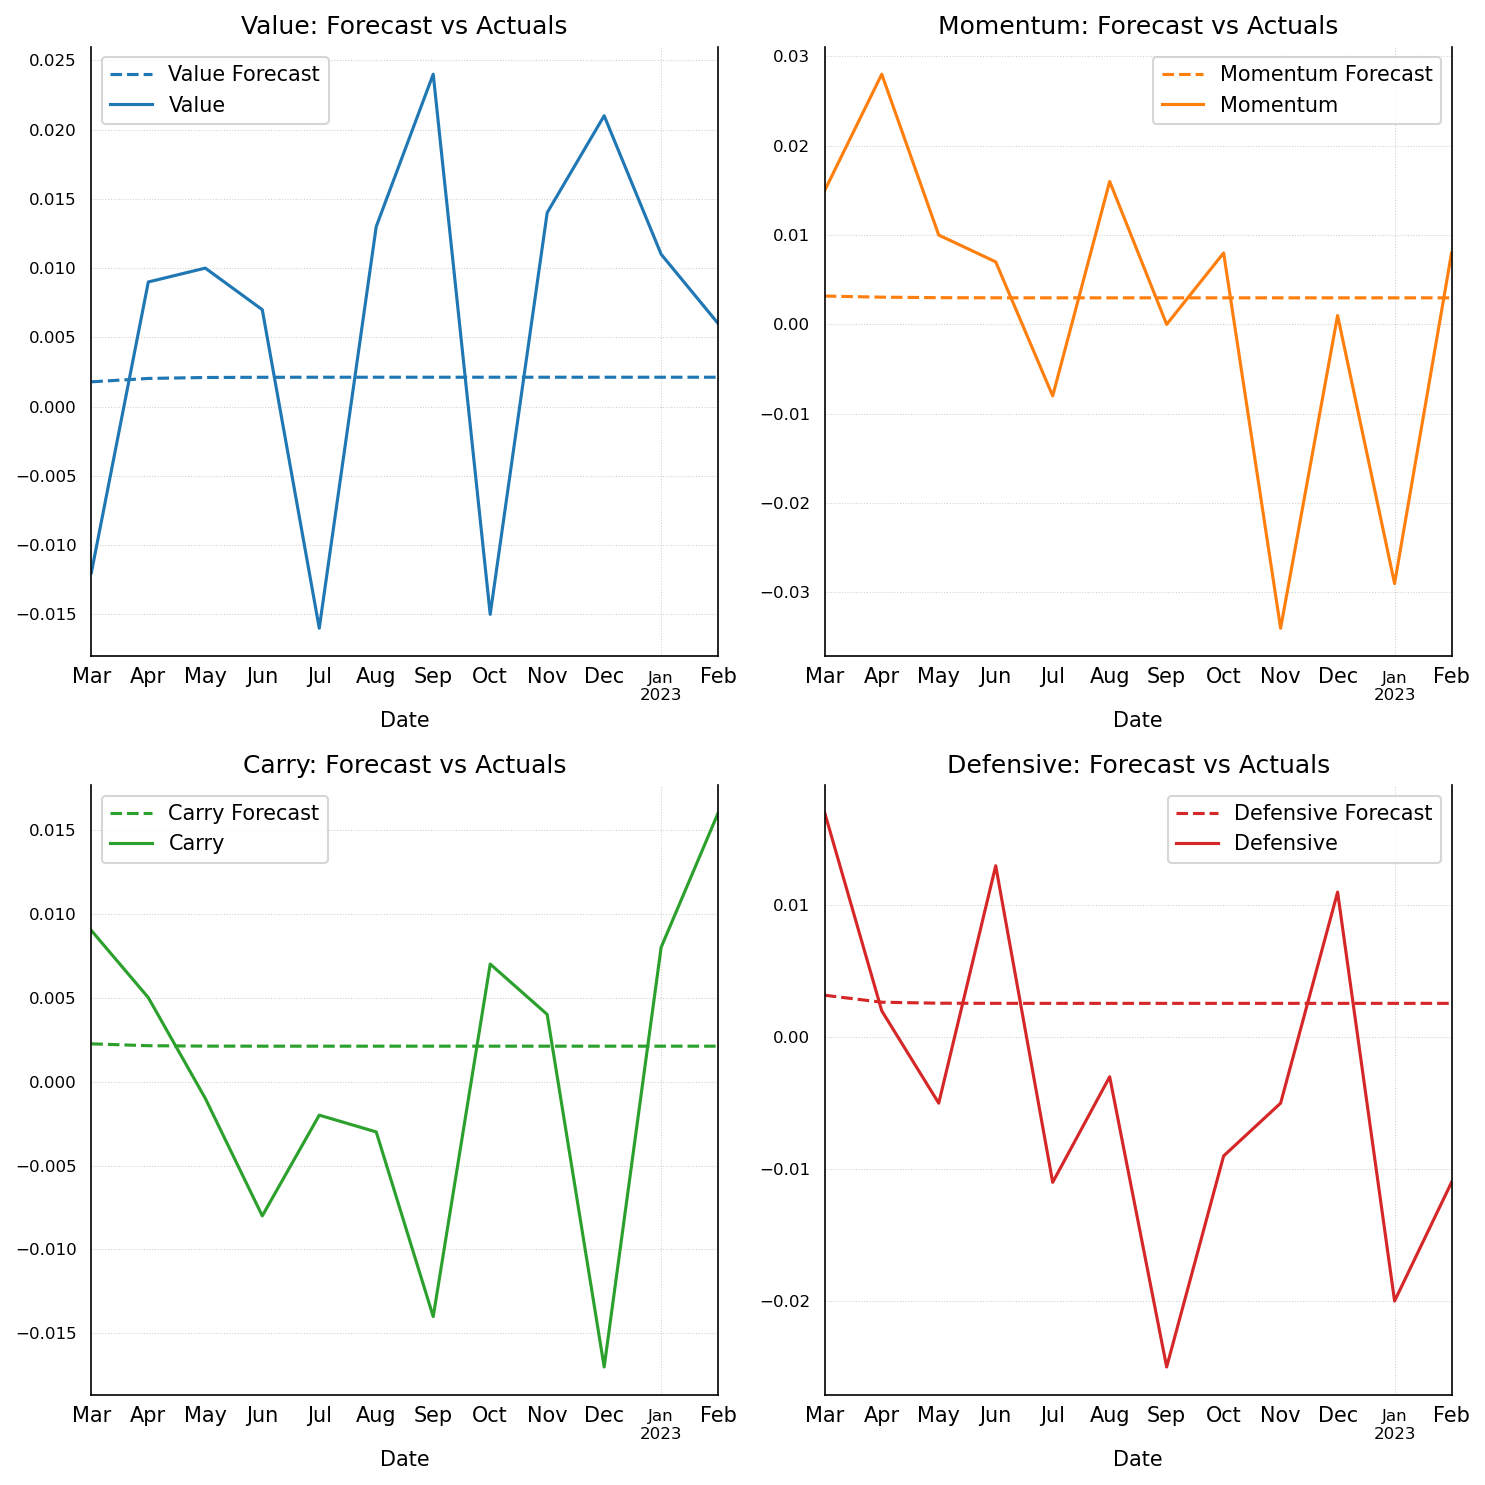

In [311]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, (col, ax) in enumerate(zip(data.columns, axes.flatten())):
    df_forecast[col + " Forecast"].plot(legend=True, ax=ax, color=colors[i], linestyle='--', linewidth=1.5).autoscale(axis='x', tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax, color=colors[i], linewidth=1.5)
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
    ax.grid(linestyle=':', linewidth=0.5, alpha=0.6)

plt.tight_layout()

It becomes evident that the forecasts are not useful, as they essentially predict the mean, which is equivalent to a naive forecast. Coupled with the non-negligible correlations in the residual matrix, the model does not appear to be useful.

Let's formally back this impression by computing the **Mean Absolute Percentage Error** (MAPE) for each factor's forecasts. MAPE is a measure of forecast accuracy, and lower values indicate better accuracy. 

In [312]:
import pandas as pd

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.where(np.abs(actual) == 0, 1, np.abs(actual)))
    return {'mape': mape}

# Create an empty DataFrame to store the results
accuracy_df = pd.DataFrame(columns=['Factor', 'MAPE'])

# Loop through columns and store forecast accuracy in the DataFrame
for col in data.columns:
    accuracy = forecast_accuracy(df_forecast[col + ' Forecast'].values, df_test[col])
    accuracy_df = accuracy_df.append({'Factor': col, 'MAPE': round(accuracy['mape'], 4)}, ignore_index=True)

# Display the results in a table
accuracy_df.style.hide_index()

Factor,MAPE
Value,0.886100
Momentum,0.880300
Carry,1.208900
Defensive,1.131200


In general, the forecast accuracy for all factors is relatively poor, as the MAPE values are quite high. This indicates that the VAR(1) model used for forecasting is not suitable for this specific data, or that additional model tuning and improvements are necessary.

Now, let's try the more advanced Multivariate LSTM model to see whether it's more useful in our setting.

### Multivariate LSTM

First, we need to prepare the dataset by scaling it and splitting it into training and testing sets. We also reshape the input data into a 3D array format that can be used as input for the LSTM model.

The lookback variable defines the number of time steps to look back in order to forecast the next time step. Theoretically backed, we decide for 36 months (3 years).
The ``MinMaxScaler`` scales the data to a range of 0 to 1. The data is split into training and testing sets with a 95:5 split.

In [313]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(X, y, lookback=1):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback), :])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

lookback = 36

# Scale the dataset
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split into train and test sets
train_size = int(len(data_scaled) * 0.95)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

# Reshape the input data into 3D array format for the LSTM model
X_train, y_train = create_dataset(train[:, :], train[:, :], lookback)
X_test, y_test = create_dataset(test[:, :], test[:, :], lookback)

Second, we ne to set up the model:

This architecture and set of hyperparameters were chosen based on some experimentation and evaluation of various options. In thre next chuck is a implementation of a hyper paramater tuning process.

- The use of a ``Conv1D`` layer can help capture temporal patterns in the input data that may be relevant.
- The use of two ``LSTM`` layers allows the model to capture complex temporal dependencies and potentially reduce the impact of vanishing gradients that can occur in deep networks.
- The addition of ``Dropout`` layers can help reduce overfitting and improve generalization performance by randomly dropping out units during training, forcing the network to learn more robust and generalized representations.

The choice of specific values for the hyperparameters (e.g., filters=32, kernel_size=3, dropout_rate=0.2, lstm_units=50, dense_units=50) involved some manual experimentation and evaluation.

In [314]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Bidirectional, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

def create_model(filters=32, kernel_size=3, dropout_rate=0.2, lstm_units=50, dense_units=50):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

To choose the hyperparamater more rigoursly a 10-fold cross-validation can be performed, using the following. However, this process if computationally extremly expensive and takes a lot of time.

In [ ]:
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=12, verbose=1)
# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=12, verbose=1)

# Define the hyperparameter search space
param_grid = {
    'filters': [16, 32, 64],
    'kernel_size': [2, 3, 4],
    'dropout_rate': [0.1, 0.2, 0.3],
    'lstm_units': [30, 50, 80],
    'dense_units': [30, 50, 80]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=1,  # Number of random combinations to try
                                   cv=10,
                                   verbose=1,
                                   n_jobs=1)

# Perform the search
random_search_result = random_search.fit(X_train, y_train)

Now, let's train the model

In [ ]:
model = create_model()

model.summary()

model.fit(X_train, y_train, epochs=50, batch_size=36, verbose=1)

The fitted model can now be used for prediction:

In [316]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 28ms/step


Since we scaled the data, we need to invert this step to get final forecasting values that can be plotted:

In [317]:
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

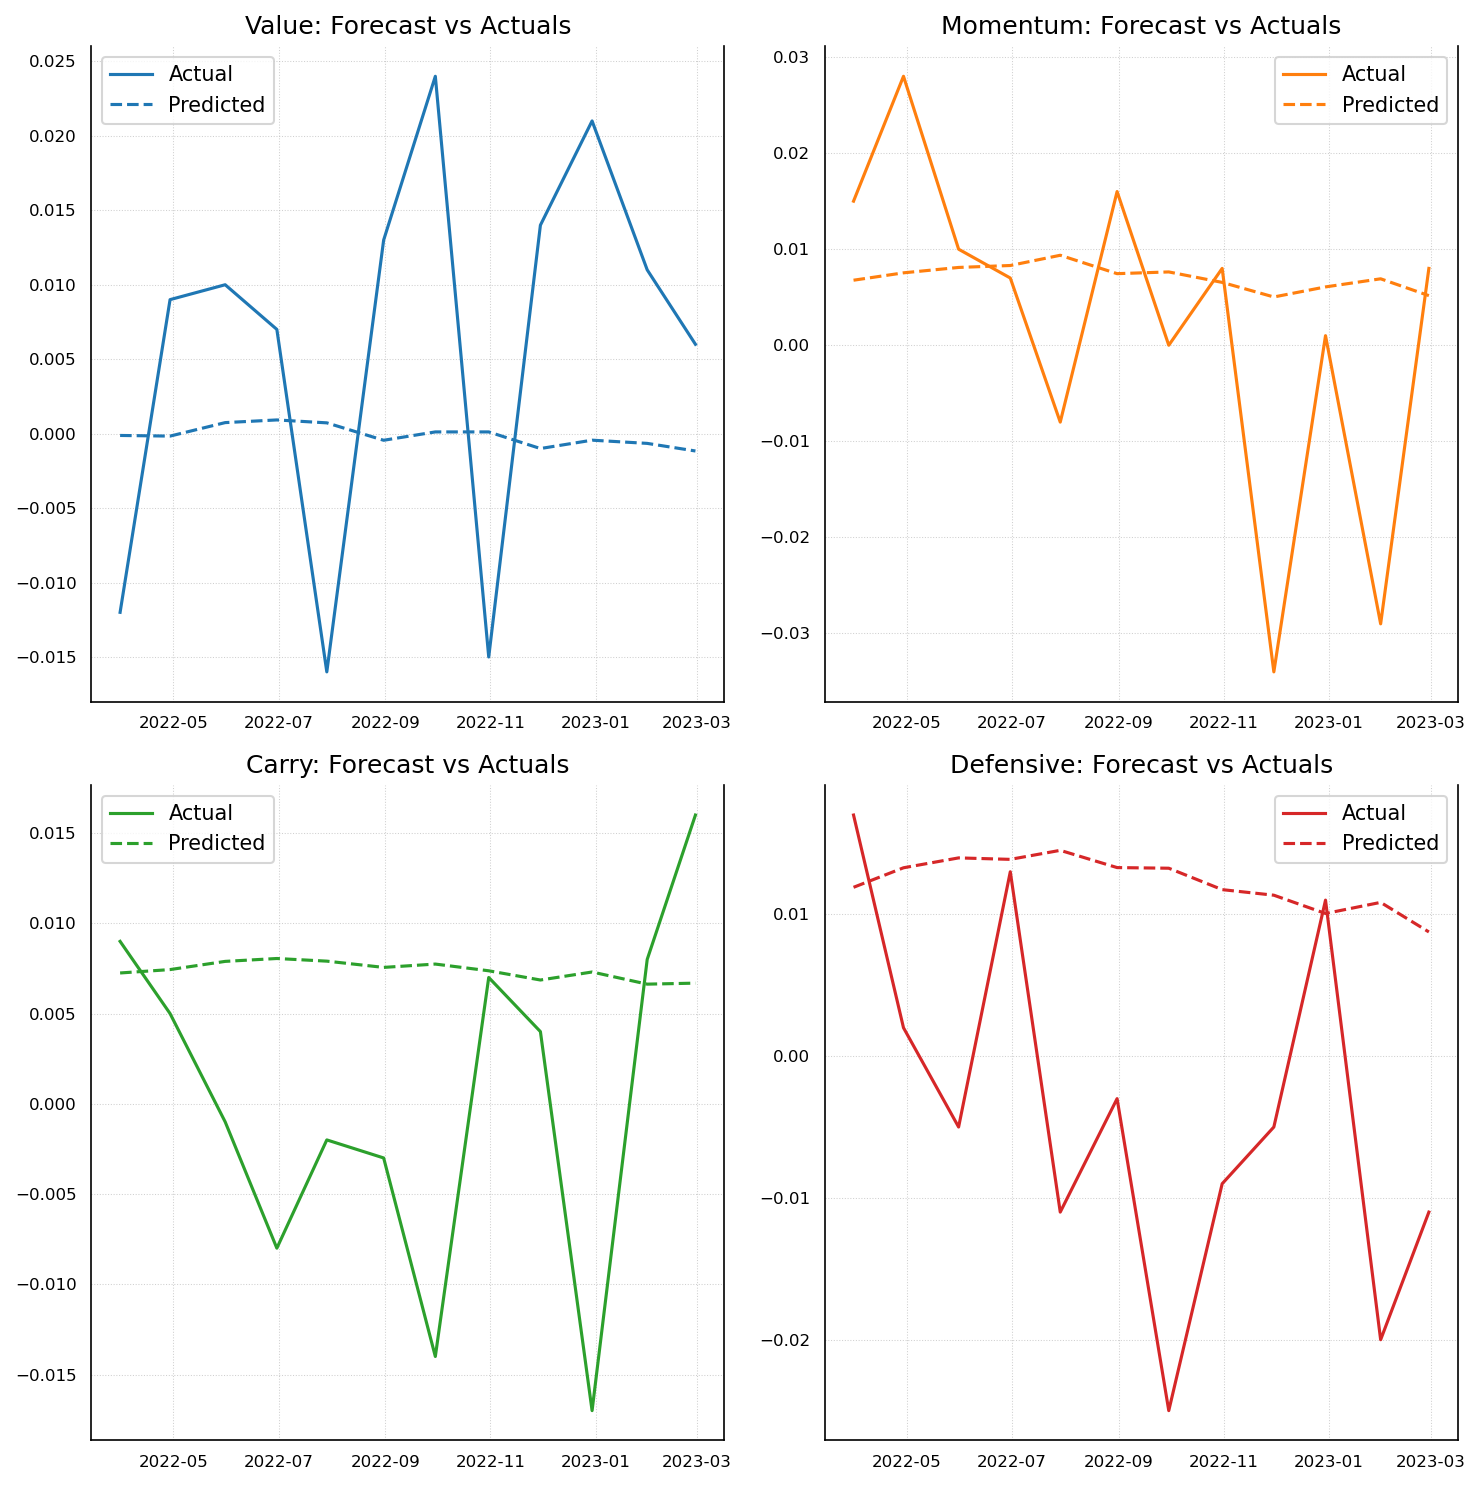

In [318]:
actual_last_12_months = y_test[-12:]
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10, 10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

last_12_months_dates = data.index[-12:]

for i, (col, ax) in enumerate(zip(data.columns, axes.flatten())):
    ax.plot(last_12_months_dates, actual_last_12_months[:, i], label="Actual", color=colors[i], linewidth=1.5)
    ax.plot(last_12_months_dates, last_12_months[:, i], label="Predicted", color=colors[i], linestyle='--', linewidth=1.5)
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
    ax.legend()
    ax.grid(linestyle=':', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

The forecasts seem to be more dynamic that the ones of the VAR model, but it is still quite bad.

To formally check our impression, let's look at the MAPE:

In [320]:
import pandas as pd

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.where(np.abs(actual) == 0, 1, np.abs(actual)))
    return {'mape': mape}

# Create an empty DataFrame to store the results
accuracy_df = pd.DataFrame(columns=['Factor', 'MAPE'])

# Obtain the last 12 months of predictions
last_12_months_preds = test_predict[-12:]

# Loop through columns and store forecast accuracy in the DataFrame
for i, col in enumerate(data.columns):
    accuracy = forecast_accuracy(last_12_months_preds[:, i], actual_last_12_months[:, i])
    accuracy_df = accuracy_df.append({'Factor': col, 'MAPE': round(accuracy['mape'], 4)}, ignore_index=True)

# Display the results in a table
accuracy_df.style.hide_index()

Factor,MAPE
Value,0.980600
Momentum,1.119400
Carry,1.016800
Defensive,1.017200


### Model Selection

To choose a model, let's compare their results:

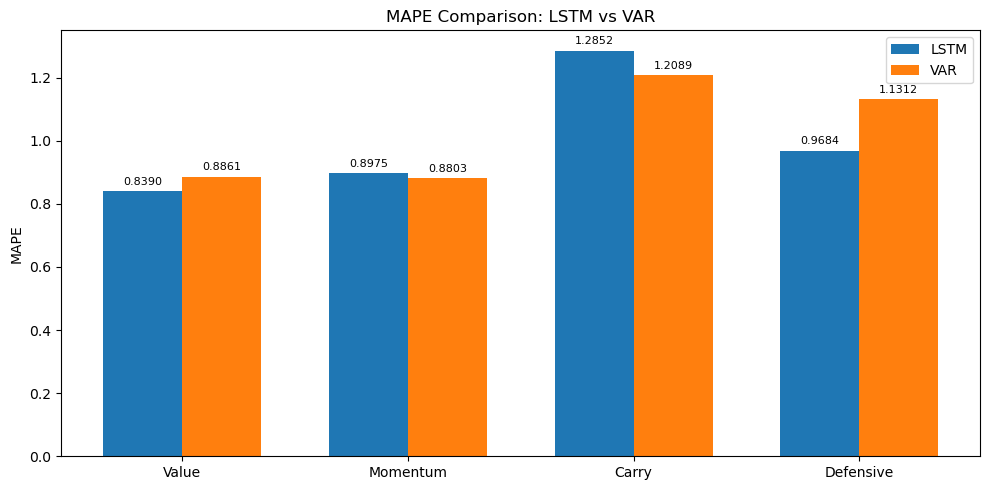

In [321]:
import matplotlib.pyplot as plt
import numpy as np

lstm_mape = [0.8390, 0.8975, 1.2852, 0.9684]
var_mape = [0.8861, 0.8803, 1.2089, 1.1312]
factors = ['Value', 'Momentum', 'Carry', 'Defensive']

x = np.arange(len(factors))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, lstm_mape, width, label='LSTM', color='tab:blue')
rects2 = ax.bar(x + width/2, var_mape, width, label='VAR', color='tab:orange')

ax.set_ylabel('MAPE')
ax.set_title('MAPE Comparison: LSTM vs VAR')
ax.set_xticks(x)
ax.set_xticklabels(factors)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Based on the comparison of MAPEs, both models exhibit strengths and weaknesses. The LSTM model outperforms the VAR model for Value and Defensive factors, while the VAR model excels in predicting Momentum and Carry factors.

To determine which model to select, we can consider the following aspects:

- If a single model is preferred for all factors, we might want to choose the one that delivers better performance for the most critical factors.
- Alternatively, a hybrid approach can be employed, utilizing the LSTM model for the Value and Defensive factors and the VAR model for the Momentum and Carry factors.

Ultimately, the differences in performance are marginal, leading us to consider **Occam's Razor** and select the simpler model, i.e., the VAR. The fact that a more complex model, like LSTM, does not significantly improve the results could suggest that the features, i.e. past returns, may not be a reliable predictor of future returns, a notion commonly accepted in the field. Garbage in, garbage out.

## Conclusion

In this analysis, we aimed to forecast the multivariate behavior of four investment strategies using multivariate forecasting techniques. We trained two multivariate models, namely the Vector Autoregression (VAR) and Long Short-Term Memory (LSTM) models.

Key Finding: The additional complexity of the LSTM model is not worth the increase in performance, if given at all. Maybe after Hyper-Paramater Tuning, this changes, but this takes a lot of time and computational ressources, beyond the scope of this project.

For future analysis, we recommend the following next steps:

- Investigate alternative models or additional features that could potentially improve the forecasting performance. For example, incorporating macroeconomic variables or market sentiment data could offer insights into the relationships between the factors and their future performance.
- Consider using other techniques, such as ensemble methods, to further improve the forecasting capabilities of the models.
- Perform a more in-depth analysis of the individual factors and their underlying drivers to better understand the reasons behind their performance.
- Test the robustness of the models using different periods or investment horizons to assess their performance under various market conditions and ensure their generalizability.